# Introduction à l’apprentissage non supervisé avec le clustering

Lino Galiana  
2025-12-26

<div class="badge-container"><div class="badge-text">Pour essayer les exemples présents dans ce tutoriel :</div><a href="https://github.com/linogaliana/python-datascientist-notebooks/blob/main/notebooks/modelisation/5_clustering.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=github&label=&message=View%20on%20GitHub&color=181717" alt="View on GitHub"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/vscode-python?autoLaunch=true&name=«5_clustering»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-vscode.sh»&init.personalInitArgs=«modelisation%205_clustering»" target="_blank" rel="noopener"><img src="https://custom-icon-badges.demolab.com/badge/SSP%20Cloud-Lancer_avec_VSCode-blue?logo=vsc&logoColor=white" alt="Onyxia"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&name=«5_clustering»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-jupyter.sh»&init.personalInitArgs=«modelisation%205_clustering»" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSP%20Cloud-Lancer_avec_Jupyter-orange?logo=Jupyter&logoColor=orange" alt="Onyxia"></a>
<a href="https://colab.research.google.com/github/linogaliana/python-datascientist-notebooks-colab//blob/main//notebooks/modelisation/5_clustering.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a><br></div>

L’ensemble de la partie *machine learning* utilise le même jeu de données, présenté dans l’[introduction de cette partie](index.qmd) : les données de vote aux élections présidentielles américaines croisées à des variables sociodémographiques. Le code est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).

In [ ]:
!pip install geopandas openpyxl plotnine plotly

In [ ]:
import pandas as pd

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

Il peut également être utile d’installer `plotnine`
pour réaliser des graphiques simplement :

In [ ]:
!pip install plotnine

# 1. Introduction sur le *clustering*

Jusqu’à présent, nous avons fait de l’apprentissage supervisé puisque nous
connaissions la vraie valeur de la variable à expliquer/prédire (`y`). Ce n’est plus le cas avec
l’apprentissage non supervisé.

Le *clustering* est un champ d’application de l’apprentissage non-supervisé.
Il s’agit d’exploiter l’information disponible en regroupant des observations
qui se ressemblent à partir de leurs caractéristiques (*features*) communes.

<details>

<summary>

Rappel: l’arbre de décision des méthodes `Scikit`

</summary>

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/Scikit-learn_machine_learning_decision_tree.png)

</details>

L’objectif est de créer des groupes d’observations (*clusters*) pour lesquels :

-   Au sein de chaque cluster, les observations sont homogènes (variance intra-cluster minimale) ;
-   Les clusters ont des profils hétérogènes, c’est-à-dire qu’ils se distinguent les uns des autres (variance inter-cluster maximale).

En *Machine Learning*, les méthodes de clustering sont très utilisées pour
faire de la recommandation. En faisant, par exemple, des classes homogènes de
consommateurs, il est plus facile d’identifier et cibler des comportements
propres à chaque classe de consommateurs.

Ces méthodes ont également un intérêt en économie et sciences sociales parce qu’elles permettent
de regrouper des observations sans *a priori* et ainsi interpréter une variable
d’intérêt à l’aune de ces résultats. Cette [publication sur la ségrégation spatiale utilisant des données de téléphonie mobile](https://www.insee.fr/fr/statistiques/4925200)
utilise par exemple cette approche.
Dans certaines bases de données, on peut se retrouver avec quelques exemples labellisés mais la plupart sont
non labellisés. Les labels ont par exemple été faits manuellement par des experts.

> **Note**
>
> <div class="callout callout-style-default callout-note callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Note
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> Les méthodes de *clustering* peuvent aussi intervenir en amont d’un problème de classification (dans des
> problèmes d’apprentissage semi-supervisé).
> Le manuel *Hands-on machine learning with scikit-learn, Keras et TensorFlow* (Géron 2022) présente dans le
> chapitre dédié à l’apprentissage non supervisé quelques exemples.
>
> Par exemple, supposons que dans la [base MNIST des chiffres manuscrits](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST), les chiffres ne soient pas labellisés
> et que l’on se demande quelle est la meilleure stratégie pour labelliser cette base.
> On pourrait regarder des images de chiffres manuscrits au hasard de la base et les labelliser.
> Les auteurs du livre montrent qu’il existe toutefois une meilleure stratégie.
> Il vaut mieux appliquer un algorithme de clustering en amont pour regrouper les images ensemble et avoir une
> image représentative par groupe, et labelliser ces images représentatives au lieu de labelliser au hasard.
>
> </div>
> </div>

Les méthodes de *clustering* sont nombreuses.
Nous allons nous pencher sur la plus intuitive : les *k-means*.

# 2. Les k-means

## 2.1 Principe

L’objectif des *k-means* est de partitionner l’espace des observations en trouvant des points (*centroids*) jouant le rôle de centres de gravité pour lesquels les observations proches peuvent être regroupées dans une classe homogène.
L’algorithme *k-means* fonctionne par itération, en initialisant les centroïdes puis en les mettant à jour à chaque
itération, jusqu’à ce que les centroïdes se stabilisent. Quelques exemples de *clusters* issus de la méthode *k-means* :

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_001.png)

> **Tip**
>
> <div class="callout callout-style-default callout-tip callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Tip
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> L’objectif des *k-means* est de trouver une partition des données $S=\{S_1,...,S_K\}$ telle que
> $$
> \arg\min_{S} \sum_{i=1}^K \sum_{x \in S_i} ||x - \mu_i||^2
> $$
> avec $\mu_i$ la moyenne des $x_i$ dans l’ensemble de points $S_i$.
>
> </div>
> </div>

Dans ce chapitre nous allons principalement
utiliser `Scikit`. Voici néanmoins une proposition
d’imports de packages, pour gagner du temps.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import seaborn as sns

You will need the following variables in the next exercise:

In [ ]:
# 1. Chargement de la base restreinte.
xvars = [
  'Unemployment_rate_2019', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"
]

votes = votes.dropna(subset = xvars + ["per_gop"])

df2 = votes.loc[:, xvars + ["per_gop"]]

> **Tip**
>
> <div class="callout callout-style-default callout-tip callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Exercice 1 : Principe des k-means
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> 1.  Faire un *k-means* avec $k=4$.
> 2.  Créer une variable `label` dans `votes` stockant le résultat de la typologie.
> 3.  Afficher cette typologie sur une carte.
> 4.  Choisir les variables `Median_Household_Income_2021` et `Unemployment_rate_2019` et représenter le nuage de points en colorant différemment en fonction du label obtenu. Quel est le problème ?
> 5.  Refaire les questions 2 à 5 en standardisant les variables en amont.
> 6.  Représenter la distribution du vote pour chaque *cluster*.
>
> </div>
> </div>

In [ ]:
# Question 1
model = KMeans(n_clusters=4)
model.fit(df2[xvars])

In [ ]:
# Question 3
votes['label'] = model.labels_

La carte obtenue à la question 4, qui permet de
représenter spatialement nos groupes, est
la suivante :

In [ ]:
# Question 4
p = votes.plot(column = "label", cmap = "inferno")
p.set_axis_off()

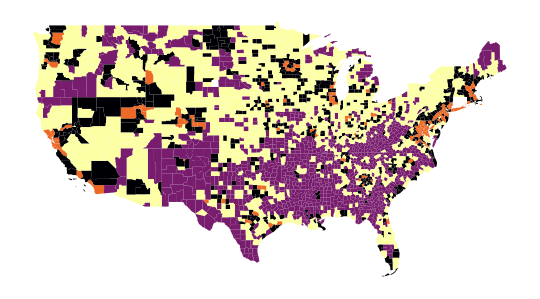

In [ ]:
p.get_figure()

Le nuage de points de la question 5, permettant de représenter
la relation entre `Median_Household_Income_2021`
et `Unemployment_rate_2019`, aura l’aspect suivant :

In [ ]:
from plotnine import *

# Question 5
votes['label'] = pd.Categorical(votes['label'])

p = (
    ggplot(votes) +
    geom_point(
        aes(
            x = "Median_Household_Income_2021",
            y = "Unemployment_rate_2019",
            color = "label"
            ),
         alpha = 0.4
    ) +
    theme_bw() + scale_x_log10()
)

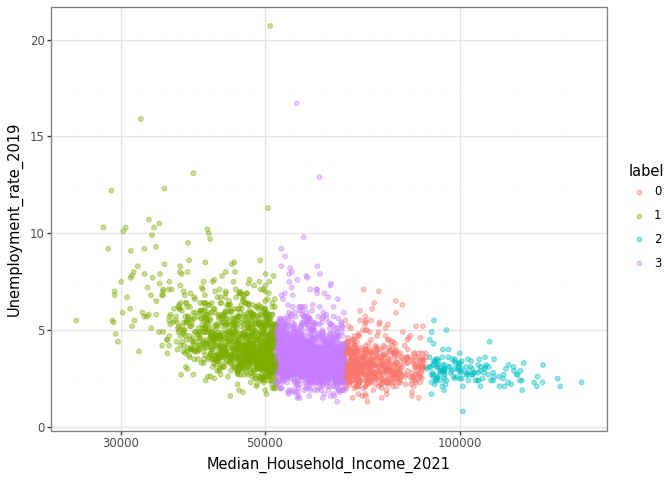

In [ ]:
p

La classification apparaît un peu trop nettement dans cette figure.
Cela suggère que la variable de revenu (`Median_Household_Income_2021`)
explique un peu trop bien le partitionnement produit par notre
modèle pour que ce soit normal. C’est probablement le fait
de la variance forte du revenu par rapport aux autres variables.
Dans ce type de situation, comme cela a été évoqué, il est
recommandé de standardiser les variables.

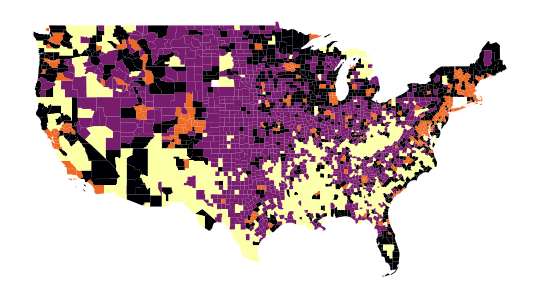

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

kmeans = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4, random_state=123)
)
kmeans.fit(df2)

votes['label'] = kmeans.predict(df2)

p = votes.plot(column = "label", cmap = "inferno")
p.set_axis_off()

On obtient ainsi la carte suivante à la question 5 :

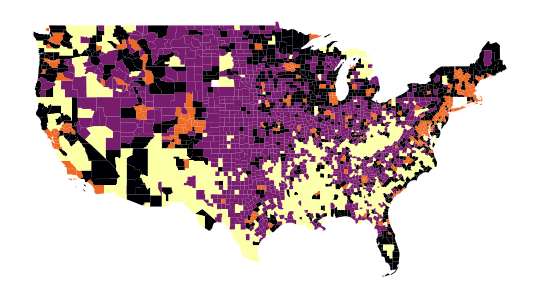

In [ ]:
p.get_figure()

Et le nuage de points de la question 5 présente un aspect moins
déterministe, ce qui est préférable :

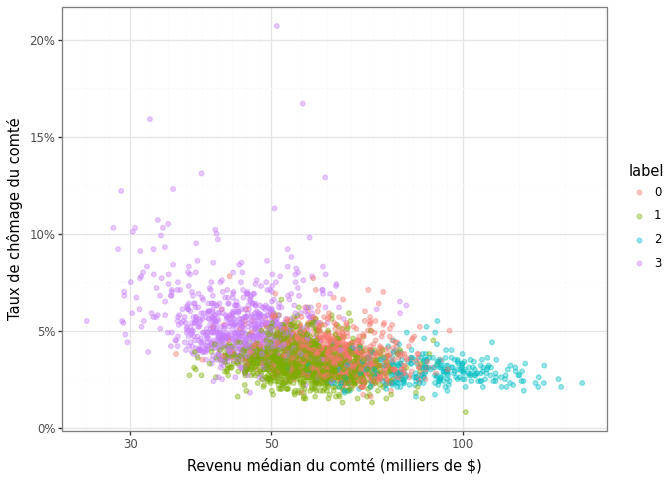

In [ ]:
from plotnine import *
from mizani.formatters import percent_format

votes['label'] = pd.Categorical(votes['label'])

(
    ggplot(votes) +
    geom_point(
        aes(
            x = "Median_Household_Income_2021/1000",
            y = "Unemployment_rate_2019/100",
            color = "label"
        ),
        alpha = 0.4
    ) +
    theme_bw() + scale_x_log10() +
    scale_y_continuous(labels=percent_format()) +
    labs(
      x = "Revenu médian du comté (milliers de $)",
      y = "Taux de chômage du comté")
)

Enfin, en ce qui concerne la question 6, on obtient cet
histogramme des votes pour chaque cluster :

In [ ]:
# Question 6
plt.figure()
p2 = (
  ggplot(votes) +
  geom_histogram(
      aes(x = "per_gop", fill = "label"), alpha = 0.2, position="identity"
      ) +
  theme_minimal()
)

> **Tip**
>
> <div class="callout callout-style-default callout-tip callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Tip
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> Il faut noter plusieurs points sur l’algorithme implémenté par défaut par `scikit-learn`, que l’on peut lire dans
> la documentation :
>
> -   l’algorithme implémenté par défaut est *kmeans++* (cf. paramètre `init`). Cela signifie que
>     l’initialisation des centroïdes est faite de manière intelligente pour que les centroïdes initiaux soient choisis
>     afin de ne pas être trop proches.
> -   l’algorithme va être démarré avec `n_init` centroïdes différents et le modèle va choisir la meilleure initialisation
>     en fonction de l’*inertie* du modèle, par défaut égale à 10.
>
> Le modèle renvoie les `cluster_centers_`, les labels `labels_`, l’inertie `inertia_` et le nombre d’itérations
> `n_iter_`.
>
> </div>
> </div>

## 2.2 Choisir le nombre de clusters

Jusqu’à présent nous avons pris comme donné le nombre de cluster, comme s’il y avait une raison légitime de penser qu’il fallait 4 plutôt que 7 profils de votes.

Comme tout (hyper)paramètre dans une approche de *machine learning* on peut vouloir jouer sur la valeur et prendre, en l’absence de théorie permettant de trancher, la moins mauvaise valeur empirique.

Il y a un arbitrage à faire entre biais et variance : un trop grand nombre de clusters implique une variance intra-cluster très faible ce qui est typique du sur-apprentissage, même s’il n’est jamais possible de déterminer le vrai type d’une observation puisqu’on est en apprentissage non supervisé.

Sans connaissance a priori du nombre de clusters, on peut recourir à deux familles de méthodes :

-   **La méthode du coude** (*elbow method*) : On prend le point d’inflexion de la courbe de performance du modèle. Cela représente le moment où ajouter un cluster supplémentaire, qui se traduit par une complexité croissante du modèle, n’apporte que des gains modérés dans la modélisation des données.

-   **Le score de silhouette** : On mesure la similarité entre un point et les autres points du cluster par rapport aux autres clusters et choisit le modèle qui permet de mieux distinguer les modèles (voir <a href="#tip-silhouette" class="quarto-xref">Tip 2.1</a>).  

> **Astuce 2.1**
>
> <div class="callout callout-style-default callout-tip callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Le score de silhouette
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> > Silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object iswell matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters
> >
> > Source: [Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering))
>
> Le score de silhouette est donc une mesure de l’arbitrage entre cohésion des clusters (dans quelle mesure les observations au sein du clusters sont homogènes) et séparation de ceux-ci (dans quelle mesure les clusters se dissocient-ils les uns des autres).
>
> Pour chaque observation $i$, la silhouette du point est
>
> $$
> s(i) = \frac{b(i)-a(i)}{\max(a(i),b(i))}
> $$
>
> avec $a(i)$ la distance moyenne entre $i$ et les autres points de son propre cluster (mesure de la cohésion) et $b(i)$ la plus petite distance moyenne entre $i$ et les points d’un autre cluster (mesure de la séparation).
>
> La valeur (s(i)) est comprise entre **-1** et **1** :
>
> -   **$s(i) \approx 1$** : $a(i) \ll b(i)$  
>     Le point est bien assigné à son cluster : il est proche des points de son cluster et loin des autres.
>
> -   **$s(i) \approx 0$** : $a(i) \approx b(i)$  
>     Le point est à la frontière entre deux clusters : la séparation est faible localement.
>
> -   **$s(i) < 0$** : $a(i) > b(i)$
>     Le point est probablement mal assigné : en moyenne, il est plus proche d’un autre cluster que du sien.
>
> Le score de silhouette est la moyenne des scores de silhouette des points.
>
> </div>
> </div>

> **Tip**
>
> <div class="callout callout-style-default callout-tip callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Exercice: déterminer le nombre optimal de partition par la méthode du coude
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> 1.  Evaluer l’inertie et la distorsion en jouant sur le nombre de *clusters* (de 1 à 9).
> 2.  Représenter graphiquement et interpréter
>
> </div>
> </div>

In [ ]:
xvars = [
  'Unemployment_rate_2019', 'Median_Household_Income_2021',
  'Percent of adults with less than a high school diploma, 2018-22',
  "Percent of adults with a bachelor's degree or higher, 2018-22"
]

df2 = votes.loc[:, xvars + ["per_gop"]].dropna()

In [ ]:
# Question 1
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

X = df2.loc[:, xvars]

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
    inertias.append(kmeanModel.inertia_)


performance_analysis = pd.DataFrame(
    {
        "K": range(1, 10),
        "distorsions": distortions,
        "inertias": inertias
    }
)

In [ ]:
def represent_performance(
  df_performance: pd.DataFrame, metric: str
):

  kmin = int(df_performance["K"].min())
  kmax = int(df_performance["K"].max())

  p = (
      ggplot(df_performance, aes(x="K", y=metric))
      + geom_line()
      + geom_point()
      + theme_minimal()
      + theme(
          axis_text_y=element_blank(),
          axis_ticks_major_y=element_blank(),
          axis_title_y=element_blank()
      )
      + scale_x_continuous(breaks=list(range(kmin, kmax + 1)))
  )

  return p

L’inertie de notre modèle est la suivante:

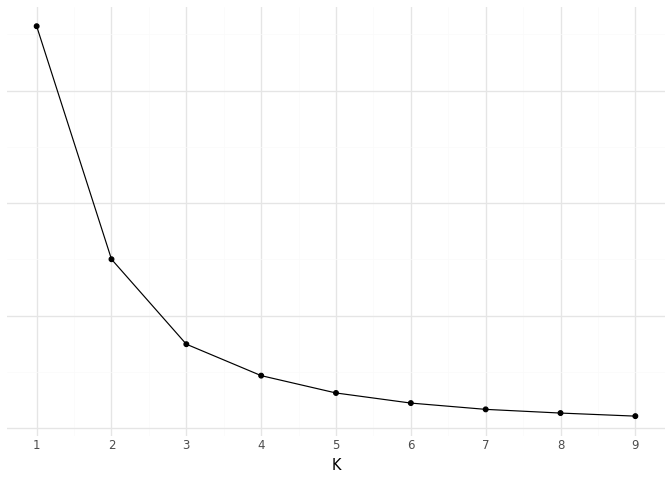

In [ ]:
represent_performance(performance_analysis, "inertias")

Là où la distorsion suit la courbe

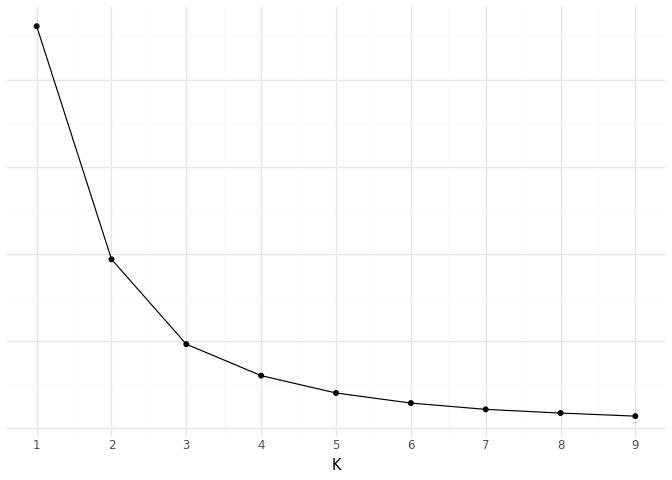

In [ ]:
represent_performance(performance_analysis, "distorsions")

## 2.3 Autres méthodes de clustering

Il existe de nombreuses autres méthodes de clustering. Parmi les plus connues, on peut citer trois exemples en particulier :

-   Le clustering ascendant hiérarchique ;
-   DBSCAN ;
-   Les mélanges de Gaussiennes.

### 2.3.1 Clustering Ascendant Hiérarchique (CAH)

Quel est le principe ?

-   On commence par calculer la dissimilarité entre nos *N* individus, *i.e.* leur distance deux à deux dans l’espace de nos variables.
-   Puis on regroupe les deux individus dont le regroupement minimise un critère d’agrégation donné, créant ainsi une classe comprenant ces deux individus.
-   On calcule ensuite la dissimilarité entre cette classe et les *N-2* autres individus en utilisant le critère d’agrégation.
-   Puis on regroupe les deux individus ou classes d’individus dont le regroupement minimise le critère d’agrégation.
-   On continue ainsi jusqu’à ce que tous les individus soient regroupés.

Ces regroupements successifs produisent un arbre binaire de classification (dendrogramme), dont la racine correspond à la classe regroupant l’ensemble des individus. Ce dendrogramme représente une hiérarchie de partitions. On peut alors choisir une partition en tronquant l’arbre à un niveau donné, le niveau dépendant soit des contraintes de l’utilisateur, soit de critères plus objectifs.

Plus d’informations [ici](https://www.xlstat.com/fr/solutions/fonctionnalites/classification-ascendante-hierarchique-cah).

### 2.3.2 DBSCAN

L’[algorithme DBSCAN](https://fr.wikipedia.org/wiki/DBSCAN) est implémenté dans `sklearn.cluster`.
Il peut être utilisé pour faire de la détection d’anomalies notamment.
En effet, cette méthode repose sur le clustering en régions où la densité
des observations est continue, grâce à la notion de voisinage selon une certaine distance epsilon.
Pour chaque observation, on va regarder si dans son voisinage selon une distance epsilon, il y a des voisins. S’il y a au
moins `min_samples` voisins, alors l’observation sera une *core instance*.

Les observations qui ne sont pas des *core instances* et qui n’en ont pas dans leur voisinage selon une distance epsilon
vont être détectées comme des anomalies.

### 2.3.3 Les mélanges de gaussiennes

En ce qui concerne la théorie, voir le cours [Probabilités numériques et statistiques computationnelles, M1 Jussieu, V.Lemaire et T.Rebafka](https://perso.lpsm.paris/~rebafka/#enseignement).
Se référer notamment aux notebooks pour l’algorithme EM pour mélange gaussien.

Dans `sklearn`, les mélanges gaussiens sont implémentés dans `sklearn.mixture` comme `GaussianMixture`.
Les paramètres importants sont alors le nombre de gaussiennes `n_components` et le nombre d’initialisations `n_init`.
Il est possible de faire de la détection d’anomalies avec les mélanges de gaussiennes.

> **Note**
>
> <div class="callout callout-style-default callout-note callout-titled">
> <div class="callout-header d-flex align-content-center">
> <div class="callout-icon-container">
> <i class="callout-icon"></i>
> </div>
> <div class="callout-title-container flex-fill">
> Pour aller plus loin
> </div>
> </div>
> <div class="callout-body-container callout-body">
>
> Il existe de nombreuses autres méthodes de clustering :
>
> -   Local outlier factor ;
> -   Bayesian gaussian mixture models ;
> -   D’autres méthodes de clustering hiérarchique ;
> -   Etc.
>
> </div>
> </div>

# 3. L’Analyse en composantes principales (ACP)

## 3.1 Pour la visualisation de clusters

La méthode la plus simple pour visualiser les *clusters*, peu importe la méthode avec laquelle ils ont été obtenus, serait de représenter chaque individu dans l’espace à *N* dimensions des variables de la table, et colorier chaque individu en fonction de son cluster.
On pourrait alors bien différencier les variables les plus discrimantes et les différents groupes.
Un seul problème ici : dès que *N \> 3*, nous avons du mal à représenter le résultat de façon intelligible…

C’est là qu’intervient l’**Analyse en Composantes Principales** ([ACP](https://www.xlstat.com/fr/solutions/fonctionnalites/analyse-en-composantes-principales-acp)), qui permet de projeter notre espace à haute dimension dans un espace de dimension plus petite.
La contrainte majeure de la projection est de pouvoir conserver le maximum d’information (mesurée par la variance totale de l’ensemble de données) dans notre nombre réduit de dimensions, appelées composantes principales.
En se limitant à 2 ou 3 dimensions, on peut ainsi se représenter visuellement les relations entre les observations avec une perte de fiabilité minimale.

On peut généralement espérer que les clusters déterminés dans notre espace à N dimensions se différencient bien sur notre projection par ACP, et que la composition des composantes principales en fonction des variables initiales permette d’interpréter les clusters obtenus.
En effet, la combinaison linéaire des colonnes donnant naissance à nos nouveaux axes a souvent un “sens” dans le monde réel :

-   Soit parce qu’une petite poignée de variables représente la majorité de la composante ;
-   Soit parce que la plupart des colonnes intervenant dans la composante sommée se combinent bien pour former une interprétation naturelle.

Pour mettre en pratique les méthodes de création de clusters, de la base brute jusqu’à la visualisation par ACP, vous pouvez consulter la partie 2 du sujet 3 du funathon 2023, *Explorer les habitudes alimentaires de nos compatriotes*, sur le [SSP Cloud](https://www.sspcloud.fr/formation?search=funath&path=%5B%22Funathon%202023%22%5D) ou sur [Github](https://github.com/InseeFrLab/funathon2023_sujet3/).

## 3.2 Pour la réduction de dimension

L’ACP est également très utile dans le champ de la réduction du nombre de variables pour de nombreux types de modélisations, comme par exemple les régressions linéaires.
Il est ainsi possible de projeter l’espace des variables explicatives dans un espace de dimension donnée plus faible, pour notamment limiter les risques d’*overfitting*.

L’inconvénient de cette approche est qu’elle rend les données utilisées en entrée du modèle moins interprétables qu’avec un LASSO puisque cette dernière technique sélectionne des variables là où la PCA sélectionne des combinaisons linéaires de nos variables.

## 3.3 Exemple

Reprenons nos données précédentes. Avant de faire une analyse en composante principale, dont l’objectif est de synthétiser des sources de variabilité dans nos données, il est conseillé de standardiser les variables lorsque celles-ci ont des échelles différentes (ce qui est le cas dans notre cas).

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df2.drop(['per_gop'], axis=1)
y = votes['winner']

print('Dimensions des données avant PCA : {}'.format(X.shape))

Dimensions des données avant PCA : (3099, 4)

Faisons déjà un premier test en réduisant nos données à deux composantes, c’est-à-dire à deux combinaisons linéaires de celles-ci. Il s’agit d’une méthode implémentée en `Scikit`, très pratique. Le faire à la main serait pénible.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

n_components = 2
pca = PCA(n_components=n_components)

Faire une PCA à la main (exercice éducatif mais peu utile dans la vraie vie)

::::

Géron, Aurélien. 2022. *Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow*. " O’Reilly Media, Inc.".